# Goos-Hanchen experiment
***

This notebook contains the data reduced from the usual Larmor Mantid reduction file. The experiment took place at Larmor beamline at ISIS from Nov 14-20th 2023. The reduced data is also contained in this github repository along with copies of the experiment log and pictures of the physical setup.

While the goal is to measure the Goos-Hanchen spatial shift of the two neutron spin states, it seems at the moment that we can only experimentally measure the phase shift between the two spin states. Again, the issue of the intrinsic coherence length of neutron pops up: Quan has shown some interesting potentially-observable effects in the different regiemes, but it is unclear how to exactly experimentally produce his proposed setups.

***
### Sample information
The two identical samples (assuming natural abundances) consist of the following layers with scattering length densities (SLDs) given in units of 10^-6 A^-2:
1. 50 nm Ti, SLD = -1.910
2. 50 nm Fe-Co-V 50-48-2%:
   1. Nuclear: SLD = 5.121
   2. Magnetic: SLD = -5.451 and 5.409
   3. Total: SLD = -0.33 and 10.53
4. 50 nm SiO_2, SLD = 2.06
5. 50 nm Fe-Co-V 50-48-2%
6. 100 nm Ni-Mo 88-12% (non-magnetic), SLD = -8.52
7. SiO_2 substrate (total size 100 mm x 50 mm x 0.78 mm)

The sample can be magnetized in a ~200 G field.

We also have two identical non-magnetic blanks:
1. 100 nm Ni-Mo 88-12%
2. Si substrate (total size 100 mm x 50 mm x 0.78 mm)

***
### Problems/questions:
1. The film's easy axis and the plane of incidence are orthogonal: therefore, the beam size on target will be cut in half if we want the remnant mangetization to be parallel to the guide field at the sample position (vertical direction)
   1. ~~We can stack the two films back-to-back to create a better return loop for the magnetic flux lines at the sample position.~~
   2. ~~We can also try wrapping the sample in a thin layer of iron foil to close the flux loop.~~
   3. After discussion, we think that this will not be a problem because the sample is so thin, the dipole field should fall to zero quickly enough to be negligible.
2. Which detector should we use?
3. Does the position of the sample stack change the echo?
4. Do we need a slit after the sample?
   1. Yes, to remove the direct beam

***
### Current experimental plan:
1. Mount and measure the blank
   1. Critical edge at .01 A^-1
   2. Want the max signal to be at 4 AA, gives grazing angle of ??? and maximum beam width of 0.4 mm
2. Mount and measure the magnetic sample with poleshoes at 90 degrees (i.e. NSE mode)
   1. Need a very tight resolution (kHz ?) 
   2. Tight divergence, no more than 0.02 degrees?
3. Rotate the sample by 90 degrees (M parallel to guide field) and redo measurement
4. Change poleshoe angle to introduce splitting in the transverse horizontal direction
5. Put phase grating after the sample
   1. The grating may act like a "Goos-Hanchen" analyzer, meaning that we could tell the difference between the phase shift and spatial shift
   2. Can use the old "compass mount" from the coherence measurement for the grating

## Functions and constants

In [1]:
import numpy as np
import sympy as sym
import scipy as sc
import sympy as sym
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science','notebook', 'grid','default','bright'])
SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = 15,18,20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size

sym.init_printing()

DEFAULT_PLOT_PARMS = {'title':'','xlab':'','ylab':'','multi_plot':True,'size':(8,5),'lw':3}  #mutliplot not implemented yet
SLD_PLOT_PARMS = DEFAULT_PLOT_PARMS|{'xlab':'Depth [AA]','ylab':'SLD [1e-6 AA^-2]','labels':['']}

def plot_function(xdata,ydata,plot_parms=DEFAULT_PLOT_PARMS):
    '''General function to plot given data.'''
    assert len(xdata) == len(ydata), 'Len mismatch between x and y data!'
    fig,ax = plt.subplots(figsize=plot_parms['size'])
    
    for indx,(x,y) in enumerate(zip(xdata,ydata)):
        ax.plot(x,y,'--',linewidth=plot_parms['lw'],label=plot_parms['labels'][indx])
    ax.set(title=plot_parms['title'],xlabel=plot_parms['xlab'],ylabel=plot_parms['ylab'])
    if plot_parms['labels'] is not None: plt.legend()

    plt.grid()
    plt.tight_layout()
    plt.show()

## Analytic calculations

Interaction matrix:


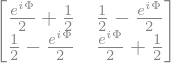

In [2]:
def get_su2_state(theta=0,phi=0,alpha=None,beta=None,gamma=0):
    '''Returns spin state, either with the usual parameterization or two complex numbers.'''
    if alpha is None or beta is None:
        result = [sym.cos(theta/2),sym.sin(theta/2)*sym.exp(sym.I*phi)]
    else:
        norm = sym.sqrt(sym.abs(alpha)**2 + sym.abs(beta)**2)
        result = 1/norm*[alpha,beta]
    return sym.exp(sym.I*gamma)*sym.Matrix(result).applyfunc(sym.simplify)

def get_op(a=0,b=0,c=0,d=0):
    '''Returns general operator in terms of the pauli vector.'''
    result = a*sym.eye(2) + b*sym.Matrix([[0,1],[1,0]]) + \
    c*sym.Matrix([[0,-sym.I],[sym.I,0]]) + d*sym.Matrix([[1,0],[0,-1]])
    return result.applyfunc(sym.simplify)

def get_proj(op,sign=1):
    '''Returns up/down projection operator.'''
    assert sign == -1 or sign == 1, 'The sign must be +/-1.'
    return (sym.Rational(1,2)*(sym.eye(2) + sign*op)).applyfunc(sym.simplify)

def expect(lstate,op,rstate=None,force_real=True):
    '''Returns the expectation value from the given state and operator.'''
    if rstate is None: rstate = lstate
    result = (lstate.H*op*rstate)[0]
    if force_real: result = sym.re(result)
    return result.simplify()

def change_basis(op,new):
    '''Returns operator in new basis.'''
    return (new.inv()*op*new).applyfunc(sym.simplify)

def time_av(func,var,N=1):
    '''Returns time average over N periods'''
    integral = func.integrate((var,-sym.pi*N,sym.pi*N))
    return (integral/(2*sym.pi*N)).expand().simplify()

p0,p1,p2,t1,t2,P1,P2,P = sym.symbols(r'\phi_0,\phi_1,\phi_2,\theta_1,\theta_2,\Phi_1,\Phi_2,\Phi',real=True)
idt,spx,spy,spz = get_op(a=1),get_op(b=1),get_op(c=1),get_op(d=1)

#asummes the magnetization is along the x-direction and incident polarization is along z
x_cob = 1/sym.sqrt(2)*sym.Matrix([[1,1],[1,-1]])
interaction = change_basis(sym.diag(1,sym.exp(sym.I*P)),x_cob)
print('Interaction matrix:')
display(interaction.applyfunc(sym.simplify))

Evolution of the spin states:


'Initial state:'

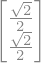

'First arm:'

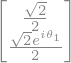

'After interaction:'

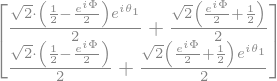

'Second arm:'

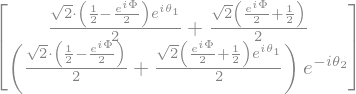

In [3]:
print('Evolution of the spin states:')
psi0 = get_su2_state(theta=sym.pi/2,phi=0)  #phi_0=0 for incident polarization along x-direction
display('Initial state:',psi0)
psi1 = get_op(a=(1+sym.exp(sym.I*t1))/2,d=(1-sym.exp(sym.I*t1))/2)*psi0
display('First arm:',psi1)
psi2 = interaction*psi1
display('After interaction:',psi2)
psi3 = get_op(a=(1+sym.exp(-sym.I*t2))/2,d=(1-sym.exp(-sym.I*t2))/2)*psi2
display('Second arm:',psi3)

Final polarization components
Px:


At echo, theta_1 = theta_2


Echo averaged


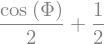



Py:


At echo, theta_1 = theta_2


Echo averaged




Pz:


At echo, theta_1 = theta_2


Echo averaged


In [5]:
Pols = []
print('Final polarization components')
for i,k in zip(['Px','Py','Pz'],[spx,spy,spz]):
    print(f'{i}:')
    pk = expect(psi3,k).subs(p0,0).expand().simplify()
    display(pk)
    Pols.append(pk)  #saving this value
    print('At echo, theta_1 = theta_2')
    pk = pk.subs(t2,t1).expand().simplify()
    display(pk)
    print('Echo averaged')
    pk = time_av(pk,t1)
    display(pk)
    print('\n')

Final polarization components
P_+x:


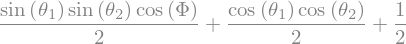

When theta_1 = -theta_2


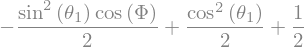

Echo averaged


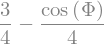



P_-x:


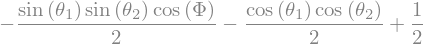

When theta_1 = -theta_2


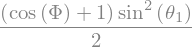

Echo averaged


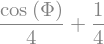



P_x:


When theta_1 = -theta_2


Echo averaged


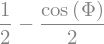

In [6]:
Pols2 = []
print('Final polarization components')
for i,k in zip(['P_+x','P_-x','P_x'],[get_proj(spx,sign=1),get_proj(spx,sign=-1),spx]):
    print(f'{i}:')
    pk = expect(psi3,k).subs(p0,0).expand().simplify()
    display(pk)
    Pols2.append(pk)  #saving this value
    print('When theta_1 = -theta_2')
    pk = pk.subs(t2,-t1).expand().simplify()
    display(pk)
    print('Echo averaged')
    pk = time_av(pk,t1)
    display(pk)
    print('\n')

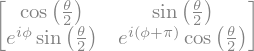

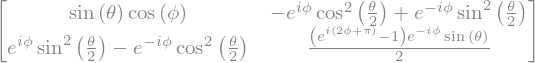

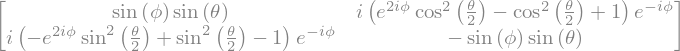

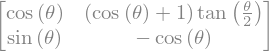

In [17]:
nm,theta,phi = sym.symbols(r'n_m,\theta,\phi',real=True)  #general interaction matrix calculation
c1,c2 = get_su2_state(theta=theta,phi=phi),get_su2_state(theta=sym.pi-theta,phi=phi+sym.pi)
gen_basis = sym.Matrix(np.hstack([c1,c2]))
display(gen_basis)

gen_mag = change_basis(spx,gen_basis)
display(gen_mag.applyfunc(sym.simplify))

gen_mag = change_basis(spy,gen_basis)
display(gen_mag.applyfunc(sym.simplify))

gen_mag = change_basis(spz,gen_basis)
display(gen_mag.applyfunc(sym.simplify))

## Numerical reflectivity calculations

In [ ]:
LAMS = np.linspace(3,10,200)  #wavelength range at Larmor (AA)

def get_crit(SLD,lam=LAMS,degrees=True):
    '''Returns critical angle.'''
    result = lam*np.sqrt(SLD/np.pi)
    if degrees: result *= 180/np.pi
    return result

def get_pot(SLDs=[],ts=[],plot=False,plot_parms=SLD_PLOT_PARMS):
    '''Returns the potential given the thicknesses and SLDs of each layer.
    Doesn't include substrate.'''
    total_x = np.linspace(0,np.sum(ts),500)
    steps = np.array([np.sum(ts[:i]) for i in range(len(ts)+1)])
    potential = np.sum([SLDs[indx]*((steps[indx]<=total_x)&(total_x<=steps[indx+1])) for indx in range(len(SLDs))],axis=0)
    if plot: plot_function([total_x],[potential],plot_parms)
    return potential,total_x

def get_SLD(nuc,spin,mag):
    '''Returns total scattering length density.'''
    return nuc

#check up vs down SLDs
SLDs = {'Ti':-1.910,'FeCoV_nuc':5.121,'FeCoV_up':-0.33,'FeCoV_down':10.53,'Si':2.06,'NiMo':-8.52}

sample_ts = np.array([50,50,50,50,100])*10  #convert to Angstroms
blank_ts = np.array([100])*10

sample_nuc_SLDs = [SLDs['Ti'],SLDs['FeCoV_nuc'],SLDs['Si'],SLDs['FeCoV_nuc'],SLDs['NiMo']]
sample_up_SLDs = [SLDs['Ti'],SLDs['FeCoV_up'],SLDs['Si'],SLDs['FeCoV_up'],SLDs['NiMo']]
sample_down_SLDs = [SLDs['Ti'],SLDs['FeCoV_down'],SLDs['Si'],SLDs['FeCoV_down'],SLDs['NiMo']]
blank_SLDs = [SLDs['NiMo']]

sample_nuc,X = get_pot(sample_nuc_SLDs,ts=sample_ts,\
                       plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('nuc','up','down')})
sample_up,_ = get_pot(sample_up_SLDs,ts=sample_ts,\
                      plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('up')})
sample_down,_ = get_pot(sample_down_SLDs,ts=sample_ts,\
                        plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('down')})
blank,Xb = get_pot(blank_SLDs,ts=blank_ts,\
                   plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('blank')})

plot_function([X,X,X,Xb],[sample_nuc,sample_up,sample_down,blank],\
              plot_parms=SLD_PLOT_PARMS|{'title':'Sample','labels':('nuc','up','down','blank')})

In [ ]:
def get_R(SLDs,ts,k0=1,substrate=SLDs['Si']):
    '''Given a potential, returns the reflectivity. Assumes air for z<=0 and 
    an additional infinite-thickness substrate layer.'''
    assert len(SLDs) == len(ts), 'Check number of layers!'
    km = [k0*(1 - 2*np.pi*rho*1e-6/k0**2) for rho in [0.]+SLDs+[substrate]]
    ms = len(km)  #air 0, layers (1,...,N), substrate N+1
    
    phim = [0]+[km[i]*ts[i] for i in range(ms-2)]  #phi_0 special case
    
    tm = [2*km[i]/(km[i] + km[i+1]) for i in range(ms-1)]
    rm = [(km[i] - km[i+1])/(km[i] + km[i+1]) for i in range(ms-1)]

    Rm = [np.array([[1,rm[i]],[rm[i],1]]) for i in range(ms-1)]
    Cm = [1/tm[i]*np.diag((np.exp(-1j*phim[i]),np.exp(1j*phim[i])))@Rm[i] for i in range(ms-1)]

    t_matrix = np.identity(2)
    for C in Cm:
        t_matrix = np.matmul(t_matrix,C)
    R = (np.abs(t_matrix[1,0])/np.abs(t_matrix[0,0]))**2
    return np.where(R>1,1,R)  #manually including the critical angle

#print(get_R(sample_nuc_SLDs,sample_ts,k0=2*np.pi/4*.00275),'\n')

angles = np.linspace(.1,.25,2000)[1:]*np.pi/180  #incident angle
#R = np.array([get_R(sample_nuc_SLDs,sample_ts,k0=2*np.pi/4*a) for a in angles])
R_up = np.array([get_R(sample_up_SLDs,sample_ts,k0=2*np.pi/4*a) for a in angles])
R_down = np.array([get_R(sample_down_SLDs,sample_ts,k0=2*np.pi/4*a) for a in angles])

plt.figure(figsize=(10,5))
#plt.plot(angles*180/np.pi,R,'-',label='nuc',lw=2)
plt.plot(angles*180/np.pi,R_up,'-',label='up',lw=2)
plt.plot(angles*180/np.pi,R_down,'-',label='down',lw=2)
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$R=|r|^2$')
plt.ylim(-.025,1.025)
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(angles*180/np.pi,(R_up-R_down)/(R_up+R_down),'-',lw=2)
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'Pol')
plt.ylim(-1.025,1.025)
plt.grid()
plt.show()

## Experiment log
***

### 11/14 Day One
Setup and calibration of the beamline.

* 9:30
* We decided that the magnetization of the sample will probbaly not be a problem because the sample is so thin. Therefore we will not worry about the mismatch of the sample field direction and the guide field direction.
* Still need to magnetize the sample today and finish the sample holder.

* 2:00
* Found the echo before lunch, need to finish building the sample holder and check the echo as we scan the sample stage (should only need a few mm of drive)
* Should we use a supermirror or a blank for tuning echo?
* Aligning the sample slit with the transmission monitor

* 7:00
* Decided to run echo scans overnight to test the long-term stability of the echo point because we cannot retune the echo once we put the magnetic sample in the beam. Also included a scan of the sample stack translation.
* Tomorrow need to write down all of the slit distances and aperture sizes.

### 11/15 Day Two
text

## Testing space
***